In [1]:
import datetime
import decimal
import pydantic
import enum
from typing import *
import warnings
import QuantLib as ql
import pandas as pd
import numpy as np
import logging

import finsec as fs

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
    # filename='my_application.log',
    # filemode='a'
)

In [2]:
# fs.fixed_income_objs.Period(period='1y').model_dump()

## autoeload info:
%load_ext autoreload
%autoreload 2

In [3]:
# BusinessDayConvention.following.to_ql()
# BusinessDayConvention.from_ql(ql.Following)

In [4]:
import json
import functools
from operator import add, sub, mul

T = TypeVar('T')
ListOrT = Union[List[T], T]

ql.Settings.instance().evaluationDate = ql.Date(3, 1, 2025)

usd_ccy = fs.FiatCurrency( ticker='USD', gsid='USD')
usd = usd_ccy
# usd = fs.create_reference_from_security(usd_ccy)

eur_ccy = fs.FiatCurrency( ticker='EUR', gsid='EUR')
eur = eur_ccy
# eur = fs.create_reference_from_security(eur_ccy)

In [5]:
acc1 = fs.AccrualInfo(
    start=datetime.date(2025,1,1),
    # end=datetime.date(2025,11,5),
    end='3m',
    period='1m',
    dc=fs.DayCount.Thirty360,
    front_stub_not_back=False,
)
# acc1.as_ql().dates()
print(len(acc1))
acc1.schedule().to_df()

3


,start,end,frac
0,2025-01-01,2025-02-01,0.083333
1,2025-02-01,2025-03-01,0.083333
2,2025-03-01,2025-04-01,0.083333


In [6]:
print(json.dumps(json.loads(acc1.model_dump_json()), indent=4))
fs.AccrualInfo.model_validate_json(acc1.model_dump_json())

{
    "start": "2025-01-01",
    "end": {
        "period": "3M"
    },
    "dc": "30/360",
    "freq": null,
    "cal_accrual": "null",
    "cal_pay": "null",
    "period": {
        "period": "1M"
    },
    "bdc": "F",
    "front_stub_not_back": false,
    "eom": false
}


AccrualInfo(start=datetime.date(2025, 1, 1), end=Period("3M"), dc=<DayCount.Thirty360: '30/360'>, freq=None, cal_accrual=<Calendar.NULL: 'null'>, cal_pay=<Calendar.NULL: 'null'>, period=Period("1M"), bdc=<BusinessDayConvention.following: 'F'>, front_stub_not_back=False, eom=False)

In [7]:
expr1 = fs.FixedRate(rate=decimal.Decimal('0.05')) * (decimal.Decimal('1')/10) + 10

expr1.get_fixing(None), expr1.is_constant

(Decimal('10.005'), True)

In [8]:
dc = ql.Actual360()

# for x in dir(dc):
#     print(x)

In [9]:
expr1.model_dump()

{'components': [{}, {}], 'operator': <ExprOperator.ADD: 'ADD'>}

In [10]:
ntnl = 1_000_000
fixleg1 = fs.Leg(
    ccy=usd,
    notional=ntnl,
    cpn=fs.FixedRate(rate=decimal.Decimal('0.01')),
    acc=fs.AccrualInfo(
        start=datetime.date(2025,1,1),
        end=datetime.date(2026,1,1),
        dc=fs.DayCount.Thirty360,
        freq=12,
        bdc=fs.BusinessDayConvention.unadjusted,
    )
)
# print(fixleg1)

bnd1 = fs.Bond(
    notional=ntnl,
    leg=fixleg1,
    # settle: datetime.date
    settle_days=1
)
print(bnd1)
ql_bnd1 = bnd1.as_quantlib()

notional=Decimal('1000000') leg=Leg(ccy=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]), notional=Decimal('1000000'), cpn=FixedRate(rate=Decimal('0.01'), is_constant=True, is_float=False), acc=AccrualInfo(start=datetime.date(2025, 1, 1), end=datetime.date(2026, 1, 1), dc=<DayCount.Thirty360: '30/360'>, freq=Decimal('12'), cal_accrual=<Calendar.NULL: 'null'>, cal_pay=<Calendar.NULL: 'null'>, period=None, bdc=<BusinessDayConvention.unadjusted: 'U'>, front_stub_not_back=True, eom=False), pay_delay=None, log=<Logger Leg (DEBUG)>) settle_days=1 credit_index=None face=100 settle=None redemption=None log=<Logger Bond (DEBUG)>


In [11]:
bnd1.cashflows_df().style.format({'amount':'{0:,.2f}'})

2025-11-09 13:17:04,240 - DEBUG - matplotlib - matplotlib data path: /config/workspace/venv/lib/python3.12/site-packages/matplotlib/mpl-data
2025-11-09 13:17:04,248 - DEBUG - matplotlib - CONFIGDIR=/config/.config/matplotlib


2025-11-09 13:17:04,268 - DEBUG - matplotlib - interactive is False
2025-11-09 13:17:04,269 - DEBUG - matplotlib - platform is linux
2025-11-09 13:17:04,359 - DEBUG - matplotlib - CACHEDIR=/config/.cache/matplotlib
2025-11-09 13:17:04,361 - DEBUG - matplotlib.font_manager - Using fontManager instance from /config/.cache/matplotlib/fontlist-v390.json


,start,end,frac,date,amount,has_occurred,rate
0,2025-01-01,2025-02-01,0.083333,2025-02-01,833.33,False,0.010000
1,2025-02-01,2025-03-01,0.083333,2025-03-01,833.33,False,0.010000
2,2025-03-01,2025-04-01,0.083333,2025-04-01,833.33,False,0.010000
3,2025-04-01,2025-05-01,0.083333,2025-05-01,833.33,False,0.010000
4,2025-05-01,2025-06-01,0.083333,2025-06-01,833.33,False,0.010000
5,2025-06-01,2025-07-01,0.083333,2025-07-01,833.33,False,0.010000
6,2025-07-01,2025-08-01,0.083333,2025-08-01,833.33,False,0.010000
7,2025-08-01,2025-09-01,0.083333,2025-09-01,833.33,False,0.010000
8,2025-09-01,2025-10-01,0.083333,2025-10-01,833.33,False,0.010000
9,2025-10-01,2025-11-01,0.083333,2025-11-01,833.33,False,0.010000


In [12]:
bnd1.model_dump()

/config/workspace/venv/lib/python3.12/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `decimal` - serialized value may not be as expected [field_name='face', input_value=100, input_type=int])
  return self.__pydantic_serializer__.to_python(


{'notional': Decimal('1000000'),
 'leg': {'ccy': {'gsid': 'USD',
   'ticker': 'USD',
   'security_type': <SecurityType.CURRENCY: 2>,
   'security_subtype': <SecuritySubtype.NATIONAL_FIAT: 505>,
   'identifiers': [],
   'primary_exchange': None,
   'denominated_ccy': None,
   'issuer': None,
   'description': None,
   'website': None,
   'as_of_date': None,
   'version_id': None},
  'notional': Decimal('1000000'),
  'cpn': {'rate': Decimal('0.01'), 'is_constant': True, 'is_float': False},
  'acc': {'start': datetime.date(2025, 1, 1),
   'end': datetime.date(2026, 1, 1),
   'dc': <DayCount.Thirty360: '30/360'>,
   'freq': Decimal('12'),
   'cal_accrual': <Calendar.NULL: 'null'>,
   'cal_pay': <Calendar.NULL: 'null'>,
   'period': None,
   'bdc': <BusinessDayConvention.unadjusted: 'U'>,
   'front_stub_not_back': True,
   'eom': False},
  'pay_delay': None},
 'settle_days': 1,
 'credit_index': None,
 'face': 100,
 'settle': None,
 'redemption': None}

In [13]:
bnd2 = fs.Bond.model_validate_json(bnd1.model_dump_json())
bnd2.model_dump()

/config/workspace/venv/lib/python3.12/site-packages/pydantic/main.py:528: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `decimal` - serialized value may not be as expected [field_name='face', input_value=100, input_type=int])
  return self.__pydantic_serializer__.to_json(


{'notional': Decimal('1000000'),
 'leg': {'ccy': {'gsid': 'USD',
   'ticker': 'USD',
   'security_type': <SecurityType.CURRENCY: 2>,
   'security_subtype': <SecuritySubtype.NATIONAL_FIAT: 505>,
   'identifiers': [],
   'primary_exchange': None,
   'denominated_ccy': None,
   'issuer': None,
   'description': None,
   'website': None,
   'as_of_date': None,
   'version_id': None},
  'notional': Decimal('1000000'),
  'cpn': {'rate': Decimal('0.01'), 'is_constant': True, 'is_float': False},
  'acc': {'start': datetime.date(2025, 1, 1),
   'end': datetime.date(2026, 1, 1),
   'dc': <DayCount.Thirty360: '30/360'>,
   'freq': Decimal('12'),
   'cal_accrual': <Calendar.NULL: 'null'>,
   'cal_pay': <Calendar.NULL: 'null'>,
   'period': None,
   'bdc': <BusinessDayConvention.unadjusted: 'U'>,
   'front_stub_not_back': True,
   'eom': False},
  'pay_delay': None},
 'settle_days': 1,
 'credit_index': None,
 'face': Decimal('100'),
 'settle': None,
 'redemption': None}

In [14]:
bnd1.model_dump()

{'notional': Decimal('1000000'),
 'leg': {'ccy': {'gsid': 'USD',
   'ticker': 'USD',
   'security_type': <SecurityType.CURRENCY: 2>,
   'security_subtype': <SecuritySubtype.NATIONAL_FIAT: 505>,
   'identifiers': [],
   'primary_exchange': None,
   'denominated_ccy': None,
   'issuer': None,
   'description': None,
   'website': None,
   'as_of_date': None,
   'version_id': None},
  'notional': Decimal('1000000'),
  'cpn': {'rate': Decimal('0.01'), 'is_constant': True, 'is_float': False},
  'acc': {'start': datetime.date(2025, 1, 1),
   'end': datetime.date(2026, 1, 1),
   'dc': <DayCount.Thirty360: '30/360'>,
   'freq': Decimal('12'),
   'cal_accrual': <Calendar.NULL: 'null'>,
   'cal_pay': <Calendar.NULL: 'null'>,
   'period': None,
   'bdc': <BusinessDayConvention.unadjusted: 'U'>,
   'front_stub_not_back': True,
   'eom': False},
  'pay_delay': None},
 'settle_days': 1,
 'credit_index': None,
 'face': 100,
 'settle': None,
 'redemption': None}

In [15]:
from functools import reduce
from operator import add

# help(reduce)
fs.Calendar.US_SOFR.bump(datetime.date(2025, 1, 1), '10y')

[datetime.date(2035, 1, 2)]

In [16]:
swp_ntnl = 1_000_000
swp_start = datetime.date(2025,1,3)
swp_end = '3y'
swp_index = 'SOFR'
swp = fs.Swap.make_ois(
    ccy=usd,
    start=swp_start,
    end=swp_end,
    rate=5.0 / 100,
    dc_fix=fs.DayCount.Actual360,
    dc_float=fs.DayCount.Actual360,
    freq_fix=1,
    freq_float=1,
    index=swp_index,
    cal_pay=fs.Calendar.US_SOFR,
    notional=swp_ntnl,
    pay_delay=fs.Period(period='2d'),
)
display(swp.model_dump())

{'legs': ({'ccy': {'gsid': 'USD',
    'ticker': 'USD',
    'security_type': <SecurityType.CURRENCY: 2>,
    'security_subtype': <SecuritySubtype.NATIONAL_FIAT: 505>,
    'identifiers': [],
    'primary_exchange': None,
    'denominated_ccy': None,
    'issuer': None,
    'description': None,
    'website': None,
    'as_of_date': None,
    'version_id': None},
   'notional': Decimal('1000000'),
   'cpn': {'rate': Decimal('0.05'), 'is_constant': True, 'is_float': False},
   'acc': {'start': datetime.date(2025, 1, 3),
    'end': {'period': '3Y'},
    'dc': <DayCount.Actual360: 'act/360'>,
    'freq': Decimal('1'),
    'cal_accrual': <Calendar.NULL: 'null'>,
    'cal_pay': <Calendar.US_SOFR: 'us/sofr'>,
    'period': None,
    'bdc': <BusinessDayConvention.following: 'F'>,
    'front_stub_not_back': True,
    'eom': False},
   'pay_delay': None},
  {'ccy': {'gsid': 'USD',
    'ticker': 'USD',
    'security_type': <SecurityType.CURRENCY: 2>,
    'security_subtype': <SecuritySubtype.NATIONA

In [17]:
ql_curve_raw = ql.FlatForward(
    0,
    fs.Calendar.US_SOFR.as_ql(),
    ql.QuoteHandle(ql.SimpleQuote(
        0.05,
    )),
    ql.Actual360(),
)

ql_curve = ql.YieldTermStructureHandle(ql_curve_raw)

swp_engine = ql.DiscountingSwapEngine(ql_curve)
sofr_idx = ql.Sofr(ql_curve)
swp_lookup = {
    'SOFR': sofr_idx,
}


In [18]:
ql_swp = swp.as_quantlib( index_lookup=swp_lookup )

ql_swp.setPricingEngine(swp_engine)
ql_swp.fairRate()

0.05114746391826529

In [19]:
swp.fixed_leg.cashflows_df(index_lookup=swp_lookup)

,start,end,frac,amount,has_occurred,rate
date,,,,,,
2026-01-05,2025-01-03,2026-01-03,1.013889,50694.444444,False,0.05
2027-01-04,2026-01-03,2027-01-03,1.013889,50694.444444,False,0.05
2028-01-03,2027-01-03,2028-01-03,1.013889,50694.444444,False,0.05


In [20]:
swp.cashflows_df( index_lookup=swp_lookup )

,start,end,frac,amount,has_occurred,rate,fix
date,,,,,,,
2026-01-05,2025-01-03,2026-01-03,1.013889,50694.444444,False,0.050000,True
2026-01-05,2025-01-03,2026-01-03,1.013889,-52001.419591,False,0.051289,False
2027-01-04,2026-01-03,2027-01-03,1.013889,50694.444444,False,0.050000,True
2027-01-04,2026-01-03,2027-01-03,1.013889,-51709.247697,False,0.051001,False
2028-01-03,2027-01-03,2028-01-03,1.013889,50694.444444,False,0.050000,True
2028-01-03,2027-01-03,2028-01-03,1.013889,-51855.298137,False,0.051145,False


In [21]:
# help(ql.MakeOIS)
ql_swp2 = ql.MakeOIS(
    ql.Period(swp_end),
    sofr_idx,
    0.05,
    paymentLag=2,
    paymentCalendar=ql.UnitedStates( ql.UnitedStates.SOFR ),
    paymentAdjustmentConvention=ql.Following,
    endOfMonth=False,
)
ql_swp2.setPricingEngine(swp_engine)
ql_swp2.fairRate()

0.05128905136099185

In [22]:
print(f'''
my swap: {ql_swp.fairRate():,.3%}
makeois: {ql_swp2.fairRate():,.3%}
diff: {(ql_swp.fairRate()-ql_swp2.fairRate())*10000:+,.2f}bp
''')



my swap: 5.115%
makeois: 5.129%
diff: -1.42bp



In [23]:
# help(ql.DiscountingSwapEngine)
# help(ql.DatedOISRateHelper)
# swp.fixed_leg.as_quantlib()

display(swp.fixed_leg.acc.model_dump())
display(swp.float_leg.acc.model_dump())
# swp.fixed_leg.acc.schedule().model_dump()

fs.Quote(quote=0).handle

{'start': datetime.date(2025, 1, 3),
 'end': {'period': '3Y'},
 'dc': <DayCount.Actual360: 'act/360'>,
 'freq': Decimal('1'),
 'cal_accrual': <Calendar.NULL: 'null'>,
 'cal_pay': <Calendar.US_SOFR: 'us/sofr'>,
 'period': None,
 'bdc': <BusinessDayConvention.following: 'F'>,
 'front_stub_not_back': True,
 'eom': False}

{'start': datetime.date(2025, 1, 3),
 'end': {'period': '3Y'},
 'dc': <DayCount.Actual360: 'act/360'>,
 'freq': Decimal('1'),
 'cal_accrual': <Calendar.NULL: 'null'>,
 'cal_pay': <Calendar.US_SOFR: 'us/sofr'>,
 'period': None,
 'bdc': <BusinessDayConvention.following: 'F'>,
 'front_stub_not_back': True,
 'eom': False}

<QuantLib.QuantLib.QuoteHandle; proxy of <Swig Object of type 'Handle< Quote > *' at 0x7f7c7b575ec0> >

In [24]:
swp.as_quantlib_helper(index_lookup=swp_lookup)


2025-11-09 13:17:04,966 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:04,967 - DEBUG - Swap - Building single-ccy swap helper


(Quote(quote=<QuantLib.QuantLib.SimpleQuote; proxy of <Swig Object of type 'ext::shared_ptr< SimpleQuote > *' at 0x7f7c7b577900> >),
 <QuantLib.QuantLib.DatedOISRateHelper; proxy of <Swig Object of type 'ext::shared_ptr< DatedOISRateHelper > *' at 0x7f7c7b577a50> >)

In [25]:
help(ql.IborIndex)

Help on class IborIndex in module QuantLib.QuantLib:

class IborIndex(InterestRateIndex)
 |  IborIndex(*args)
 |
 |  Proxy of C++ IborIndex class.
 |
 |  Method resolution order:
 |      IborIndex
 |      InterestRateIndex
 |      Index
 |      Observable
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, *args)
 |      __init__(IborIndex self, std::string const & familyName, Period tenor, Integer settlementDays, Currency currency, Calendar calendar, BusinessDayConvention convention, bool endOfMonth, DayCounter dayCounter, YieldTermStructureHandle h=Handle< YieldTermStructure >()) -> IborIndex
 |
 |  __repr__ = _swig_repr(self) from QuantLib.QuantLib
 |
 |  businessDayConvention(self)
 |      businessDayConvention(IborIndex self) -> BusinessDayConvention
 |
 |  clone(self, arg2)
 |      clone(IborIndex self, YieldTermStructureHandle arg2) -> ext::shared_ptr< IborIndex >
 |
 |  endOfMonth(self)
 |      endOfMonth(IborIndex self) -> bool
 |
 |  forwardingTermStruc

## bootstrap a treasury curve

In [26]:
class SingleCurveConfig(pydantic.BaseModel):
    name: Hashable
    date: datetime.date
    settle_days: int
    dc: fs.DayCount
    cal: fs.Calendar

    # parallel_bump:fs.Quote = pydantic.Field(default_factory=fs.Quote)
    resets: Dict[datetime.date, decimal.Decimal] = pydantic.Field(default_factory=dict)
    helpers: Dict[str, Tuple[fs.Quote, Any]] = pydantic.Field(default_factory=dict)

    ql_curve_raw: ql.YieldTermStructure|None=None
    handle: ql.RelinkableYieldTermStructureHandle=pydantic.Field(default_factory=ql.RelinkableYieldTermStructureHandle)
    index: ql.InterestRateIndex|None=None

    class Config:
        arbitrary_types_allowed = True
    
    def benchmarks(self)->Dict[str, fs.Quote]:
        return { n:q[0] for n,q in self.helpers.items() }

    def add_helper(self, name:str, quote:fs.Quote, helper:Any):
        self.helpers[name] = (quote, helper)
    
    def add_reset(self, dt:datetime.date, rate:decimal.Decimal):
        self.resets[dt] = rate
        if self.index is not None:
            self.index.addFixing( ql.Date.from_date(dt), float(rate))
    
    def build_quantlib_index(self):
        usd = ql.USDCurrency()
        self.index = ql.OvernightIndex(
            self.name,
            self.settle_days,
            usd,
            self.cal.as_ql(),
            self.dc.as_ql,
            self.handle
        )
        self.index.addFixings(
            [ql.Date.from_date(x) for x in self.resets.keys()],
            [float(x) for x in self.resets.values()],
        )

    def build_quantlib_curve(self):
        instruments = [x[1] for x in self.helpers.values()]
        self.ql_curve_raw = ql.PiecewiseFlatForward(
            ql.Date.from_date(self.date),
            instruments,
            self.dc.as_ql,
        )
        self.handle.linkTo(self.ql_curve_raw)
    
    # def plot_forwards()

# class CurveInterp(pydantic.BaseModel):
#     order: List[Literal[0,1,2]]
#     joint_date:

/tmp/ipykernel_2408297/2539767883.py:1: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  class SingleCurveConfig(pydantic.BaseModel):


In [27]:
tsy_curve = SingleCurveConfig(
    name='USGOVT',
    date=datetime.date(2025, 1, 1),
    settle_days=1,
    dc=fs.DayCount.ActualActual,
    cal=fs.Calendar.US_GovernmentBond,
)

In [28]:
bond_tenors = ['1y','2y','5y','10y']
bonds = [
    fs.Bond(
        credit_index='USGOVT',
        notional=ntnl,
        leg=fs.Leg(
            ccy=usd,
            notional=100,
            cpn=fs.FixedRate(rate=5.0 / 100),
            acc=fs.AccrualInfo(
                start=datetime.date(2025,1,1),
                end=ten,
                dc=fs.DayCount.ActualActual,
                freq=2,
                bdc=fs.BusinessDayConvention.modified_following,
            )
        ),
        settle_days=1
    )
    for ten in bond_tenors
]

# bond_prices = [100] * len(bond_tenors)
bond_prices = [
    100,
    99,
    98,
    97,
]
bond_helpers = [bnd.as_quantlib_helper() for bnd in bonds]
for px, q in zip(bond_prices, bond_helpers):
    q[0].setValue(px)

In [29]:
for ten, qh in zip(bond_tenors, bond_helpers):
    q,h = qh
    tsy_curve.add_helper( ten, q, h)

In [30]:
tsy_curve.build_quantlib_curve()
tsy_curve.ql_curve_raw.enableExtrapolation()

In [31]:
# tsy_curve.plot(datetime.date(2025,1,1), datetime.date(2035,1,1))

In [32]:
# swp_crv0_ql = ql.PiecewiseFlatForward(
# )

# help(ql.PiecewiseFlatForward)
# PiecewiseFlatForward self
#     Date referenceDate
#     RateHelperVector instruments
#     DayCounter dayCounter
#     QuoteHandleVector jumps=std::vector< Handle< Quote > >()
#     DateVector jumpDates=std::vector< Date >()
#     BackwardFlat i=BackwardFlat()
#     IterativeBootstrap b=_IterativeBootstrap()

for x in dir(ql):
    if 'piecewise' in x.lower():
        print(x)

PiecewiseConstantCorrelation
PiecewiseConstantParameter
PiecewiseConvexMonotoneForward
PiecewiseConvexMonotoneZero
PiecewiseCubicZero
PiecewiseFlatForward
PiecewiseFlatHazardRate
PiecewiseForwardSpreadedTermStructure
PiecewiseKrugerLogDiscount
PiecewiseKrugerZero
PiecewiseLinearForward
PiecewiseLinearForwardSpreadedTermStructure
PiecewiseLinearZero
PiecewiseLogCubicDiscount
PiecewiseLogLinearDiscount
PiecewiseLogMixedLinearCubicDiscount
PiecewiseLogParabolicCubicDiscount
PiecewiseMonotonicLogParabolicCubicDiscount
PiecewiseMonotonicParabolicCubicZero
PiecewiseNaturalCubicZero
PiecewiseNaturalLogCubicDiscount
PiecewiseParabolicCubicZero
PiecewiseSplineCubicDiscount
PiecewiseTimeDependentHestonModel
PiecewiseYoYInflation
PiecewiseZeroInflation
PiecewiseZeroSpreadedTermStructure


In [33]:
import salt.curve as crv

today = datetime.date(2025,1,3)
ql.Settings.instance().evaluationDate = ql.Date.from_date(today)

spot_dt = fs.Calendar.US_SOFR.bump( today, '2d')[0]
print(spot_dt)

index_name = 'SOFR'

sofr_curve = crv.SingleCurveConfig(
    ccy=usd,
    name=index_name,

    date=today,
    # date=datetime.date(2025, 1, 7),
    settle_days=2,
    # date=spot_dt,
    # settle_days=0,

    dc=fs.DayCount.Actual360,
    cal=fs.Calendar.US_SOFR,
)
estr_curve = crv.SingleCurveConfig(
    ccy=eur,
    name='ESTR',
    date=today,
    settle_days=2,
    dc=fs.DayCount.Actual360,
    cal=fs.Calendar.EU_TARGET,
)
# print(sofr_curve)
curve = crv.MultiCurve(
    curves={
        index_name:sofr_curve,
        'ESTR':estr_curve,
    },
    default_curve_by_ccy={
        usd.gsid:'SOFR',
        eur.gsid:'ESTR',
    }
)
print(curve)
print(curve.index_lookup)

# bm_rates = 
# swp_ntnl = 1_000_000

swps = []
quotes = []
rate_mult = 100
bms = dict()
for ten, r in [
        ('1y',  3.610),
        ('2y',  3.331),
        ('3y',  3.270),
        ('5y',  3.311),
        ('7y',  3.427),
        ('10y', 3.608),
        ('12y', 3.717),
        ('20y', 3.943),
        ('30y', 3.922),
        ('40y', 3.817),
    ]:
    swp = fs.Swap.make_ois(
        ccy=usd,
        start=spot_dt,
        end=fs.Period(period=ten),
        rate=r/100,
        dc_fix=fs.DayCount.Actual360,
        dc_float=fs.DayCount.Actual360,
        freq_fix=1,
        freq_float=1,
        index=index_name,
        cal_pay=fs.Calendar.US_SOFR,
        pay_delay=fs.Period(period='2d'),
    )
    quote = fs.Quote(quote=ql.SimpleQuote(r))
    bms[ten] = crv.Benchmark(
        rate=quote,
        instrument=swp,
        risk_mult=1e-2,
        bootstrap_mult=1e-2,
    )

sofr_curve.bms = bms

2025-11-09 13:17:05,441 - DEBUG - SingleCurveConfig - building quantlib index for SOFR
2025-11-09 13:17:05,442 - DEBUG - SingleCurveConfig - Done building quantlib index
2025-11-09 13:17:05,442 - DEBUG - SingleCurveConfig - building quantlib index for ESTR
2025-11-09 13:17:05,443 - DEBUG - SingleCurveConfig - Done building quantlib index
2025-11-09 13:17:05,443 - DEBUG - MultiCurve - Building all curves


2025-01-07
curves={'SOFR': SingleCurveConfig(name='SOFR', ccy=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]), date=datetime.date(2025, 1, 3), settle_days=2, dc=<DayCount.Actual360: 'act/360'>, cal=<Calendar.US_SOFR: 'us/sofr'>, extrapolate=True, virgin=True, bms={}, resets={}, handle=<QuantLib.QuantLib.RelinkableYieldTermStructureHandle; proxy of <Swig Object of type 'RelinkableHandle< YieldTermStructure > *' at 0x7f7c7b7652f0> >, ql_curve_raw=None, index=<QuantLib.QuantLib.OvernightIndex; proxy of <Swig Object of type 'ext::shared_ptr< OvernightIndex > *' at 0x7f7c58fc03c0> >, log=<Logger SingleCurveConfig (DEBUG)>), 'ESTR': SingleCurveConfig(name='ESTR', ccy=Security(gsid=[EUR], ticker=[EUR], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]), date=datetime.date(2025, 1, 3), settle_days=2, dc=<DayCount.Actual360: 'act/360'>, cal=<Calendar.EU_TARGET: 'eu/target'>, extrapolate=True, virgin=True, bms={}, resets={}, handle=<QuantLi

In [34]:
swps = []
quotes = []
rate_mult = 100
bms = dict()
for ten, r in [
        ("1Y", 2.1),
        ("2Y", 2.2),
        ("3Y", 2.3),
        ("5Y", 2.5),
        ("7Y", 2.7),
        ("10Y", 2.8),
    ]:
    swp = fs.Swap.make_ois(
        ccy=eur,
        start=spot_dt,
        end=fs.Period(period=ten),
        rate=r/100,
        dc_fix=fs.DayCount.Actual360,
        dc_float=fs.DayCount.Actual360,
        freq_fix=1,
        freq_float=1,
        index='ESTR',
        cal_pay=fs.Calendar.EU_TARGET,
        # pay_delay=fs.Period(period='2d'),
    )
    quote = fs.Quote(quote=ql.SimpleQuote(r))
    bms[ten] = crv.Benchmark(
        rate=quote,
        instrument=swp,
        risk_mult=1e-2,
        bootstrap_mult=1e-2,
    )

estr_curve.bms = bms
curve.init_all_curves()
# curve = crv.MultiCurve.model_validate_json( curve.model_dump_json() )

2025-11-09 13:17:05,497 - DEBUG - MultiCurve - Building all curves
2025-11-09 13:17:05,498 - DEBUG - SingleCurveConfig - Building quantlib curve
2025-11-09 13:17:05,498 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:05,499 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:05,499 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:05,501 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:05,501 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:05,502 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:05,504 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:05,505 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:05,505 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:05,508 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:05,509 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:05,509 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:05,514 - D

2025-11-09 13:17:05,564 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:05,590 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:05,591 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:05,591 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:05,626 - DEBUG - SingleCurveConfig - Building the actual quantlib curve obj
2025-11-09 13:17:05,900 - DEBUG - SingleCurveConfig - Linking to handle
2025-11-09 13:17:05,901 - DEBUG - SingleCurveConfig - Building quantlib curve
2025-11-09 13:17:05,902 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:05,902 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:05,903 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:05,905 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:05,906 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:05,907 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:05,909 - DEBUG - salt.curve - Benchmark buildi

In [35]:
# default: 'Any' = PydanticUndefined,
# 	*,
# 	default_factory: 'Callable[[], Any] | Callable[[dict[str, Any]], Any] | None' = PydanticUndefined,
# 	alias: 'str | None' = PydanticUndefined,
# 	alias_priority: 'int | None' = PydanticUndefined,
# 	validation_alias: 'str | AliasPath | AliasChoices | None' = PydanticUndefined,
# 	serialization_alias: 'str | None' = PydanticUndefined,
# 	title: 'str | None' = PydanticUndefined,
# 	field_title_generator: 'Callable[[str, FieldInfo], str] | None' = PydanticUndefined,
# 	description: 'str | None' = PydanticUndefined,
# 	examples: 'list[Any] | None' = PydanticUndefined,
# 	exclude: 'bool | None' = PydanticUndefined,
# 	discriminator: 'str | types.Discriminator | None' = PydanticUndefined,
# 	deprecated: 'Deprecated | str | bool | None' = PydanticUndefined,
# 	json_schema_extra: 'JsonDict | Callable[[JsonDict], None] | None' = PydanticUndefined,
# 	frozen: 'bool | None' = PydanticUndefined,
# 	validate_default: 'bool | None' = PydanticUndefined,
# 	repr: 'bool' = PydanticUndefined,
# 	init: 'bool | None' = PydanticUndefined,
# 	init_var: 'bool | None' = PydanticUndefined,
# 	kw_only: 'bool | None' = PydanticUndefined,
# 	pattern: 'str | typing.Pattern[str] | None' = PydanticUndefined,
# 	strict: 'bool | None' = PydanticUndefined,
# 	coerce_numbers_to_str: 'bool | None' = PydanticUndefined,
# 	gt: 'annotated_types.SupportsGt | None' = PydanticUndefined,
# 	ge: 'annotated_types.SupportsGe | None' = PydanticUndefined,
# 	lt: 'annotated_types.SupportsLt | None' = PydanticUndefined,
# 	le: 'annotated_types.SupportsLe | None' = PydanticUndefined,
# 	multiple_of: 'float | None' = PydanticUndefined,
# 	allow_inf_nan: 'bool | None' = PydanticUndefined,
# 	max_digits: 'int | None' = PydanticUndefined,
# 	decimal_places: 'int | None' = PydanticUndefined,
# 	min_length: 'int | None' = PydanticUndefined,
# 	max_length: 'int | None' = PydanticUndefined,
# 	union_mode: "Literal['smart', 'left_to_right']" = PydanticUndefined,
# 	fail_fast: 'bool | None' = PydanticUndefined,
# 	**extra: 'Unpack[_EmptyKwargs]') -> 'Any'

In [36]:
def show_curve(crv):
    c = crv.currentLink()
    print(c)
    # for x in dir(c):
    #     if x[0] != '_':
    #         print(x)
    dt0 = c.referenceDate().to_date()
    dt1 = c.maxDate().to_date()
    print(f'{dt0.strftime("%d-%b-%y")} -> {dt1.strftime("%d-%b-%y")}')
    # print(c.dates())

# show_curve(sofr_curve.handle)

In [37]:
# hlpr = sofr_curve.bms['1y'].create_helper(curve)
# # dir(hlpr)
# hlpr.earliestDate(), hlpr.latestDate(), hlpr.pillarDate(), hlpr.quote().value()

In [38]:
swp_test_raw = fs.Swap.make_ois(
    ccy=usd,
    start=spot_dt,
    end=fs.Period(period='10y'),
    rate=3.6/100,
    dc_fix=fs.DayCount.Actual360,
    dc_float=fs.DayCount.Actual360,
    freq_fix=1,
    freq_float=1,
    index=index_name,
    cal_pay=fs.Calendar.US_SOFR,
    notional=1_000_000,
    pay_delay=fs.Period(period='2d'),
)
# swp_test = swp_test_raw.as_quantlib(index_lookup=curve.index_lookup)
# swp_test.setPricingEngine(ql.DiscountingSwapEngine(sofr_curve.handle))
# sofr_curve.benchmark_rates()

In [39]:
# dir(multi_risk.ql_obj)
# help(multi_risk.ql_obj.NPV)

In [40]:
logging.getLogger().setLevel(logging.DEBUG)

multi_risk = curve.risk_factory(
    swp_test_raw.risk_builder(
        # funding_index=curve.get_curve_handle('SOFR'),
        # funding_index='SOFR'
    ),
    # eps=1e-5
)
print(f'fair rate: {multi_risk.ql_obj.fairRate():,.3%}')
print('multi risk pv:', multi_risk.pv)
# df = multi_risk.curve['SOFR'].as_df()
# print(df['risk'].sum())
# display(df.style.format({
#     'risk':'{0:,.1f}'
# }))

# multi_risk = curve.risk_factory(
#     swp_test_raw.risk_builder(
#         # funding_index=curve.get_curve_handle('SOFR'),
#         funding_index='SOFR'
#     ),
#     eps=1e-5
# )
print(multi_risk.pv)
df = multi_risk.curve['SOFR'].as_df()
print(df['risk'].sum())
df.style.format({ ('risk','USD'):'{0:,.1f}' })

2025-11-09 13:17:06,159 - DEBUG - MultiCurve - Risk factory
2025-11-09 13:17:06,160 - DEBUG - Swap - funding curve df: 0.223641
2025-11-09 13:17:06,169 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-11-09 13:17:06,170 - DEBUG - SingleCurveConfig - Risking for 1y
2025-11-09 13:17:06,338 - DEBUG - SingleCurveConfig - Risking for 2y


2025-11-09 13:17:06,493 - DEBUG - SingleCurveConfig - Risking for 3y
2025-11-09 13:17:06,653 - DEBUG - SingleCurveConfig - Risking for 5y
2025-11-09 13:17:06,815 - DEBUG - SingleCurveConfig - Risking for 7y
2025-11-09 13:17:06,970 - DEBUG - SingleCurveConfig - Risking for 10y
2025-11-09 13:17:07,112 - DEBUG - SingleCurveConfig - Risking for 12y
2025-11-09 13:17:07,283 - DEBUG - SingleCurveConfig - Risking for 20y
2025-11-09 13:17:07,421 - DEBUG - SingleCurveConfig - Risking for 30y
2025-11-09 13:17:07,557 - DEBUG - SingleCurveConfig - Risking for 40y
2025-11-09 13:17:07,684 - DEBUG - SingleCurveConfig - Risked SOFR curve in 1513.75 ms
2025-11-09 13:17:07,685 - DEBUG - MultiCurve - Risk factory
2025-11-09 13:17:07,807 - DEBUG - Swap - funding curve df: 0.223648
2025-11-09 13:17:07,816 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-11-09 13:17:07,817 - DEBUG - SingleCurveConfig - Risking for 1y
2025-11-09 13:17:07,967 - DEBUG - SingleCurveConfig - Risking for 2y
2025-11-09 

fair rate: 3.604%
multi risk pv: security=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]) quantity=Decimal('-368.96463502338156')
security=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]) quantity=Decimal('-368.96463502338156')
USD   -842.072757
dtype: float64


,rate,risk
,,USD
1y,3.610000,-0.6
2y,3.331000,0.0
3y,3.270000,0.4
5y,3.311000,-1.8
7y,3.427000,1.4
10y,3.608000,-846.8
12y,3.717000,-0.4
20y,3.943000,5.8
30y,3.922000,-0.0


In [41]:
# curve.model_dump()
# 1/0

In [42]:
swp_test_raw = fs.Swap.make_ois(
    ccy=usd,
    start=spot_dt,
    end=fs.Period(period='8y'),
    rate=r/100,
    dc_fix=fs.DayCount.Actual360,
    dc_float=fs.DayCount.Actual360,
    freq_fix=1,
    freq_float=1,
    index=index_name,
    cal_pay=fs.Calendar.US_SOFR,
    notional=20_000_000,
    pay_delay=fs.Period(period='2d'),
)
# swp_test = swp_test_raw.as_quantlib(index_lookup=curve.index_lookup)
# swp_test.setPricingEngine(ql.DiscountingSwapEngine(sofr_curve.handle))
# sofr_curve.benchmark_rates()

multi_risk = curve.risk_factory(
    swp_test_raw.risk_builder(
        # funding_index=curve.get_curve_handle('SOFR'),
        # funding_index='SOFR'
    ),
)
print(multi_risk.pv)
df = multi_risk.curve['SOFR'].as_df()
print(df['risk'].sum())
df.style.format({ ('risk','USD'):'{0:,.1f}' })

2025-11-09 13:17:09,490 - DEBUG - MultiCurve - Risk factory
2025-11-09 13:17:09,490 - DEBUG - Swap - funding curve df: 0.223648
2025-11-09 13:17:09,499 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-11-09 13:17:09,500 - DEBUG - SingleCurveConfig - Risking for 1y
2025-11-09 13:17:09,649 - DEBUG - SingleCurveConfig - Risking for 2y
2025-11-09 13:17:09,799 - DEBUG - SingleCurveConfig - Risking for 3y
2025-11-09 13:17:09,959 - DEBUG - SingleCurveConfig - Risking for 5y
2025-11-09 13:17:10,122 - DEBUG - SingleCurveConfig - Risking for 7y
2025-11-09 13:17:10,275 - DEBUG - SingleCurveConfig - Risking for 10y
2025-11-09 13:17:10,413 - DEBUG - SingleCurveConfig - Risking for 12y
2025-11-09 13:17:10,550 - DEBUG - SingleCurveConfig - Risking for 20y
2025-11-09 13:17:10,685 - DEBUG - SingleCurveConfig - Risking for 30y
2025-11-09 13:17:10,816 - DEBUG - SingleCurveConfig - Risking for 40y
2025-11-09 13:17:10,943 - DEBUG - SingleCurveConfig - Risked SOFR curve in 1443.69 ms
2025-11-09 

security=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]) quantity=Decimal('-979950.7359021432')
USD   -13556.558
dtype: float64


,rate,risk
,,USD
1y,3.610000,0.8
2y,3.331000,21.6
3y,3.270000,55.9
5y,3.311000,74.8
7y,3.427000,"-7,884.1"
10y,3.608000,"-5,883.9"
12y,3.717000,18.4
20y,3.943000,39.9
30y,3.922000,-0.0


In [43]:
import salt.fx
# help(ql.DiscountingSwapEngine)

help(ql.FxSwapRateHelper)

Help on class FxSwapRateHelper in module QuantLib.QuantLib:

class FxSwapRateHelper(RateHelper)
 |  FxSwapRateHelper(*args)
 |
 |  Proxy of C++ FxSwapRateHelper class.
 |
 |  Method resolution order:
 |      FxSwapRateHelper
 |      RateHelper
 |      Observable
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, *args)
 |      __init__(FxSwapRateHelper self, QuoteHandle fwdPoint, QuoteHandle spotFx, Period tenor, Natural fixingDays, Calendar calendar, BusinessDayConvention convention, bool endOfMonth, bool isFxBaseCurrencyCollateralCurrency, YieldTermStructureHandle collateralCurve, Calendar tradingCalendar=Calendar()) -> FxSwapRateHelper
 |
 |  __repr__ = _swig_repr(self) from QuantLib.QuantLib
 |
 |  adjustmentCalendar(self)
 |      adjustmentCalendar(FxSwapRateHelper self) -> Calendar
 |
 |  businessDayConvention(self)
 |      businessDayConvention(FxSwapRateHelper self) -> BusinessDayConvention
 |
 |  calendar(self)
 |      calendar(FxSwapRateHelper self) ->

In [44]:
# print(json.dumps(
#     json.loads(curve.model_dump_json()),
#     indent=4,
# ))
crv.SingleCurveConfig.model_validate_json(
    sofr_curve.model_dump_json()
)

2025-11-09 13:17:12,604 - DEBUG - SingleCurveConfig - building quantlib index for SOFR
2025-11-09 13:17:12,605 - DEBUG - SingleCurveConfig - Done building quantlib index


SingleCurveConfig(name='SOFR', ccy=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]), date=datetime.date(2025, 1, 3), settle_days=2, dc=<DayCount.Actual360: 'act/360'>, cal=<Calendar.US_SOFR: 'us/sofr'>, extrapolate=True, virgin=True, bms={'1y': Benchmark(rate=Quote(quote=<QuantLib.QuantLib.SimpleQuote; proxy of <Swig Object of type 'ext::shared_ptr< SimpleQuote > *' at 0x7f7c590130c0> >), instrument=Swap(legs=(Leg(ccy=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]), notional=Decimal('10000'), cpn=FixedRate(rate=Decimal('0.0361'), is_constant=True, is_float=False), acc=AccrualInfo(start=datetime.date(2025, 1, 7), end=Period("1Y"), dc=<DayCount.Actual360: 'act/360'>, freq=Decimal('1'), cal_accrual=<Calendar.NULL: 'null'>, cal_pay=<Calendar.US_SOFR: 'us/sofr'>, period=None, bdc=<BusinessDayConvention.following: 'F'>, front_stub_not_back=True, eom=False), pay_delay=None, log=<Logger Leg (DEBUG)>), 

In [45]:
curve2 = crv.MultiCurve.model_validate_json(
    curve.model_dump_json()
)

swp_bldr = swp_test_raw.risk_builder(
    # funding_index=curve.get_curve_handle('SOFR'),
    funding_index='SOFR'
)

multi_risk2 = curve2.risk_factory( swp_bldr, eps=1e-5)
print(f'fair rate: {multi_risk2.ql_obj.fairRate():,.3%}')

# multi_risk2 = curve2.risk_factory( swp_bldr, eps=1e-5)
print(f'fair rate: {multi_risk2.ql_obj.fairRate():,.3%}')
print('multi risk pv:', multi_risk2.pv)
df = multi_risk2.curve['SOFR'].as_df()
print(df['risk'].sum())
display(df.style.format({
    'risk':'{0:,.1f}'
}))

2025-11-09 13:17:12,646 - DEBUG - SingleCurveConfig - building quantlib index for SOFR
2025-11-09 13:17:12,647 - DEBUG - SingleCurveConfig - Done building quantlib index
2025-11-09 13:17:12,651 - DEBUG - SingleCurveConfig - building quantlib index for ESTR
2025-11-09 13:17:12,652 - DEBUG - SingleCurveConfig - Done building quantlib index
2025-11-09 13:17:12,652 - DEBUG - MultiCurve - Building all curves
2025-11-09 13:17:12,652 - DEBUG - SingleCurveConfig - Building quantlib curve
2025-11-09 13:17:12,653 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:12,653 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:12,654 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:12,655 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:12,656 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:12,656 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:12,659 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:12,659 - DEBUG - 

2025-11-09 13:17:13,053 - DEBUG - SingleCurveConfig - Linking to handle
2025-11-09 13:17:13,054 - DEBUG - SingleCurveConfig - Building quantlib curve
2025-11-09 13:17:13,054 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:13,055 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:13,055 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:13,057 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:13,057 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:13,058 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:13,060 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:13,061 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:13,061 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:13,064 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:13,064 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:13,065 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:13,07

fair rate: 3.501%
fair rate: 3.501%
multi risk pv: security=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]) quantity=Decimal('-979950.7359028603')
USD   -13556.348497
dtype: float64


,rate,risk
,,USD
1y,3.610000,0.889217
2y,3.331000,21.637946
3y,3.270000,55.927189
5y,3.311000,74.813173
7y,3.427000,-7884.074736
10y,3.608000,-5883.850397
12y,3.717000,18.487874
20y,3.943000,39.989100
30y,3.922000,-0.119143


In [46]:
multi_risk2.curve['SOFR'].as_df()


2025-11-09 13:17:16,587 - DEBUG - salt.curve - returning dataframe


,rate,risk
,,USD
1y,3.610,0.889217
2y,3.331,21.637946
3y,3.270,55.927189
5y,3.311,74.813173
7y,3.427,-7884.074736
10y,3.608,-5883.850397
12y,3.717,18.487874
20y,3.943,39.989100
30y,3.922,-0.119143


In [47]:
ntnl = 1_000_000
bnd2 = fs.Bond(
    notional=ntnl,
    leg=fs.Leg(
        ccy=usd,
        notional=ntnl,
        cpn=fs.FixedRate(rate=decimal.Decimal('0.00')),
        acc=fs.AccrualInfo(
            start=datetime.date(2025,1,1),
            # end=datetime.date(2026,1,1),
            end='7y',
            dc=fs.DayCount.Thirty360,
            freq=2,
            bdc=fs.BusinessDayConvention.unadjusted,
        )
    ),
    # settle: datetime.date
    settle_days=1
)

bnd_bldr = bnd2.risk_builder( funding_index='SOFR')
multi_risk3 = curve2.risk_factory( bnd_bldr)

# print(f'fair rate: {multi_risk3.ql_obj.fairRate():,.3%}')
# multi_risk2 = curve2.risk_factory( swp_bldr, eps=1e-5)
# print(f'fair rate: {multi_risk3.ql_obj.fairRate():,.3%}')

print('multi risk pv:', multi_risk3.pv)
df2 = multi_risk3.curve['SOFR'].as_df()
print(df2['risk'].sum())
display(df2.style.format({
    'risk':'{0:,.1f}'
}))
print(multi_risk3.ql_obj.cleanPrice())

2025-11-09 13:17:16,623 - DEBUG - MultiCurve - Risk factory
2025-11-09 13:17:16,624 - DEBUG - Bond - funding curve df: 0.223648
2025-11-09 13:17:16,625 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-11-09 13:17:16,626 - DEBUG - SingleCurveConfig - Risking for 1y


2025-11-09 13:17:16,801 - DEBUG - SingleCurveConfig - Risking for 2y
2025-11-09 13:17:16,962 - DEBUG - SingleCurveConfig - Risking for 3y
2025-11-09 13:17:17,137 - DEBUG - SingleCurveConfig - Risking for 5y
2025-11-09 13:17:17,310 - DEBUG - SingleCurveConfig - Risking for 7y
2025-11-09 13:17:17,472 - DEBUG - SingleCurveConfig - Risking for 10y
2025-11-09 13:17:17,616 - DEBUG - SingleCurveConfig - Risking for 12y
2025-11-09 13:17:17,757 - DEBUG - SingleCurveConfig - Risking for 20y
2025-11-09 13:17:17,899 - DEBUG - SingleCurveConfig - Risking for 30y
2025-11-09 13:17:18,036 - DEBUG - SingleCurveConfig - Risking for 40y
2025-11-09 13:17:18,169 - DEBUG - SingleCurveConfig - Risked SOFR curve in 1543.67 ms
2025-11-09 13:17:18,170 - DEBUG - MultiCurve - Risk factory
2025-11-09 13:17:18,297 - DEBUG - Bond - funding curve df: 0.223648
2025-11-09 13:17:18,298 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-11-09 13:17:18,298 - DEBUG - SingleCurveConfig - Risking for 1y
2025-11-09 

multi risk pv: security=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]) quantity=Decimal('786938.125768183')
USD   -541.14961
dtype: float64


,rate,risk
,,USD
1y,3.610000,1.404100
2y,3.331000,5.519770
3y,3.270000,13.335150
5y,3.311000,23.059520
7y,3.427000,-585.771810
10y,3.608000,-0.286320
12y,3.717000,1.590880
20y,3.943000,-0.000300
30y,3.922000,-0.000300


78.70157008229194


In [48]:
import cProfile
# cProfile.run('curve2.risk_factory( bnd_bldr, eps=1e-5)', sort='cumtime')

In [49]:
# def new_ccy(name:str, as_reference:bool=True):
#     ccy = fs.FiatCurrency(ticker=name, gsid=name)
#     if as_reference:
#         return fs.create_reference_from_security(ccy)
#     else:
#         return ccy

# usd = new_ccy('USD')
# eur = new_ccy('EUR')
eurusd = fs.Quote(quote=1.18)

fx = salt.fx.FxBoard(
    quotes = {
        (eur.gsid, usd.gsid): eurusd,
    }
)
assert fx.get_fx_quote(eur, usd).value() == 1.18
fx.get_fx_quote(usd, eur).value(),1/1.18

(0.8474576271186441, 0.8474576271186441)

In [50]:
# for x in dir(ql):
#     if 'flat' in x.lower():
#         print(x)
list(fs.DayCount)

[<DayCount.Actual360: 'act/360'>,
 <DayCount.Actual365Fixed: 'act/365f'>,
 <DayCount.ActualActual: 'act/act'>,
 <DayCount.Thirty360: '30/360'>]

In [51]:
fx_swap = fs.Swap(
    legs=(
        fs.Leg(
            ccy=usd,
            notional=1_000_000,
            cpn=fs.FixedRate(rate=decimal.Decimal('1.00')),
            acc=fs.AccrualInfo(
                start=datetime.date(2025,1,1),
                # end=datetime.date(2026,1,1),
                end='2y',
                dc=fs.DayCount.Thirty360,
                freq=0,
                bdc=fs.BusinessDayConvention.unadjusted,
            )
        ),
        fs.Leg(
            ccy=eur,
            notional=-1_000_000,
            cpn=fs.FixedRate(rate=decimal.Decimal('1.00')),
            acc=fs.AccrualInfo(
                start=datetime.date(2025,1,1),
                # end=datetime.date(2026,1,1),
                end='2y',
                dc=fs.DayCount.Thirty360,
                freq=0,
                bdc=fs.BusinessDayConvention.unadjusted,
            )
        ),
    )
)

fl1_bldr = fx_swap.risk_builder(
    # funding_index='SOFR'
)
multi_risk4 = curve2.risk_factory( fl1_bldr )

print('multi risk pv:', multi_risk4.pv)
for k in multi_risk4.curve.keys():
    print(k)
    as_df = multi_risk4.curve[k].as_df()
    print(multi_risk4.curve[k].total_risk)
    display(as_df.style.format({
        ('risk','USD'):'{0:,.1f}',
        ('risk','EUR'):'{0:,.1f}',
    }))

2025-11-09 13:17:20,027 - DEBUG - MultiCurve - Risk factory
2025-11-09 13:17:20,028 - DEBUG - Leg - funding curve df: 0.223648
2025-11-09 13:17:20,030 - DEBUG - Leg - funding curve df: 0.753546
2025-11-09 13:17:20,031 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-11-09 13:17:20,032 - DEBUG - SingleCurveConfig - Risking for 1y


2025-11-09 13:17:20,187 - DEBUG - SingleCurveConfig - Risking for 2y
2025-11-09 13:17:20,335 - DEBUG - SingleCurveConfig - Risking for 3y
2025-11-09 13:17:20,494 - DEBUG - SingleCurveConfig - Risking for 5y
2025-11-09 13:17:20,655 - DEBUG - SingleCurveConfig - Risking for 7y
2025-11-09 13:17:20,809 - DEBUG - SingleCurveConfig - Risking for 10y
2025-11-09 13:17:20,949 - DEBUG - SingleCurveConfig - Risking for 12y
2025-11-09 13:17:21,090 - DEBUG - SingleCurveConfig - Risking for 20y
2025-11-09 13:17:21,225 - DEBUG - SingleCurveConfig - Risking for 30y
2025-11-09 13:17:21,358 - DEBUG - SingleCurveConfig - Risking for 40y
2025-11-09 13:17:21,485 - DEBUG - SingleCurveConfig - Risked SOFR curve in 1453.26 ms
2025-11-09 13:17:21,486 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-11-09 13:17:21,609 - DEBUG - SingleCurveConfig - Risking for 1Y
2025-11-09 13:17:21,641 - DEBUG - SingleCurveConfig - Risking for 2Y
2025-11-09 13:17:21,671 - DEBUG - SingleCurveConfig - Risking for 3Y
2

multi risk pv: positions=[Position(-935887.647 x USD), Position(956979.433 x EUR)]
SOFR
positions=[Position(182.83 x USD)]


,rate,risk
,,USD
1y,3.610000,-0.0
2y,3.331000,184.3
3y,3.270000,0.0
5y,3.311000,-1.5
7y,3.427000,-0.0
10y,3.608000,-0.0
12y,3.717000,-0.0
20y,3.943000,-0.0
30y,3.922000,-0.0


2025-11-09 13:17:23,559 - DEBUG - salt.curve - returning dataframe


ESTR
positions=[Position(-189.404 x EUR)]


,rate,risk
,,EUR
1Y,2.100000,-1.1
2Y,2.200000,-189.9
3Y,2.300000,-0.0
5Y,2.500000,1.6
7Y,2.700000,-0.0
10Y,2.800000,-0.0


In [52]:
import operator

# dir(multi_risk4)
# reduce(operator.add, list(multi_risk4.curve['ESTR'].risk.values()))
multi_risk4.curve['ESTR'].total_risk

Portfolio(-189.404 x EUR)

In [53]:
print(type(usd), usd)
fix_leg1 = fs.Leg(
    ccy=usd,
    notional=1_000_000,
    cpn=fs.FixedRate(rate=decimal.Decimal('1.00')),
    acc=fs.AccrualInfo(
        start=datetime.date(2025,1,1),
        # end=datetime.date(2026,1,1),
        end='2y',
        dc=fs.DayCount.Thirty360,
        freq=0,
        bdc=fs.BusinessDayConvention.unadjusted,
    )
)

qll1 = fix_leg1.as_quantlib()

fl1_bldr = fix_leg1.risk_builder( funding_index='SOFR')
multi_risk3 = curve2.risk_factory( fl1_bldr )

print('multi risk pv:', multi_risk3.pv)
df2 = multi_risk3.curve['SOFR'].as_df()
print(df2['risk'].sum())
display(df2.style.format({ ('risk','USD'):'{0:,.1f}' }))

# (np.abs(df2["risk"]) > 0).any()
# print(multi_risk3.ql_obj.cleanPrice())

2025-11-09 13:17:23,624 - DEBUG - MultiCurve - Risk factory
2025-11-09 13:17:23,625 - DEBUG - Leg - funding curve df: 0.223648
2025-11-09 13:17:23,626 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-11-09 13:17:23,626 - DEBUG - SingleCurveConfig - Risking for 1y


<class 'finsec.base.Security'> gsid='USD' ticker='USD' security_type=<SecurityType.CURRENCY: 2> security_subtype=<SecuritySubtype.NATIONAL_FIAT: 505> identifiers=[] primary_exchange=None denominated_ccy=None issuer=None description=None website=None as_of_date=None version_id=None


2025-11-09 13:17:23,787 - DEBUG - SingleCurveConfig - Risking for 2y
2025-11-09 13:17:23,947 - DEBUG - SingleCurveConfig - Risking for 3y
2025-11-09 13:17:24,118 - DEBUG - SingleCurveConfig - Risking for 5y
2025-11-09 13:17:24,293 - DEBUG - SingleCurveConfig - Risking for 7y
2025-11-09 13:17:24,460 - DEBUG - SingleCurveConfig - Risking for 10y
2025-11-09 13:17:24,609 - DEBUG - SingleCurveConfig - Risking for 12y
2025-11-09 13:17:24,758 - DEBUG - SingleCurveConfig - Risking for 20y
2025-11-09 13:17:24,902 - DEBUG - SingleCurveConfig - Risking for 30y
2025-11-09 13:17:25,047 - DEBUG - SingleCurveConfig - Risking for 40y
2025-11-09 13:17:25,183 - DEBUG - SingleCurveConfig - Risked SOFR curve in 1557.16 ms
2025-11-09 13:17:25,184 - DEBUG - MultiCurve - Risk factory
2025-11-09 13:17:25,315 - DEBUG - Leg - funding curve df: 0.223648
2025-11-09 13:17:25,316 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-11-09 13:17:25,317 - DEBUG - SingleCurveConfig - Risking for 1y
2025-11-09 1

multi risk pv: security=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]) quantity=Decimal('-935887.6472021401')
USD    182.83135
dtype: float64


,rate,risk
,,USD
1y,3.610000,-0.0
2y,3.331000,184.3
3y,3.270000,0.0
5y,3.311000,-1.5
7y,3.427000,-0.0
10y,3.608000,-0.0
12y,3.717000,-0.0
20y,3.943000,-0.0
30y,3.922000,-0.0


## Bootstrap SPX div curve from FX Futures

In [54]:
spx = fs.DerivedIndex(
    ticker="SPX",
    issuer="Standard & Poor",
    gsid='SPX',
    currency=usd,
)

# index_name = 

sofr_curve_eq = crv.SingleCurveConfig(
    ccy=usd,
    name='SOFR',
    date=today,
    settle_days=2,
    dc=fs.DayCount.Actual360,
    cal=fs.Calendar.US_SOFR,
)
spx_curve = crv.SingleCurveConfig(
    ccy=spx,
    name='SPX',
    date=today,
    settle_days=0,
    dc=fs.DayCount.Actual365Fixed,
    cal=fs.Calendar.NULL,
)

spx_usd = fs.Quote(quote=6_000)
# fx = salt.fx.FxBoard(
#     quotes = {
#         (spx.gsid, usd.gsid): spx_usd,
#     }
# )

eq_curve = crv.MultiCurve(
    curves={
        index_name:sofr_curve_eq,
        'SPX':spx_curve,
    },
    default_curve_by_ccy={
        usd.gsid:'SOFR',
        spx.gsid:'SPX',
    },
    fx = salt.fx.FxBoard(
        quotes = {
            (spx.gsid, usd.gsid): spx_usd,
        }
    ),
)


2025-11-09 13:17:26,809 - DEBUG - SingleCurveConfig - building quantlib index for SOFR
2025-11-09 13:17:26,810 - DEBUG - SingleCurveConfig - Done building quantlib index
2025-11-09 13:17:26,810 - DEBUG - SingleCurveConfig - building quantlib index for SPX
2025-11-09 13:17:26,811 - DEBUG - SingleCurveConfig - Done building quantlib index
2025-11-09 13:17:26,811 - DEBUG - MultiCurve - Building all curves


In [55]:
sofr_curve_eq.bms = {
    ten: crv.Benchmark(
        rate=fs.Quote(quote=ql.SimpleQuote(r)),
        instrument=fs.Swap.make_ois(
            ccy=usd,
            start=spot_dt,
            end=fs.Period(period=ten),
            rate=r/100,
            dc_fix=fs.DayCount.Actual360,
            dc_float=fs.DayCount.Actual360,
            freq_fix=1,
            freq_float=1,
            index=index_name,
            cal_pay=fs.Calendar.US_SOFR,
            pay_delay=fs.Period(period='2d'),
        ),
        risk_mult=1e-2,
        bootstrap_mult=1e-2,
    )
    for ten, r in [
        ('3m',  3.70),
        ('6m',  3.86),
        ('1y',  3.610),
        ('2y',  3.331),
        ('3y',  3.270),
        ('5y',  3.311),
        ('7y',  3.427),
        ('10y', 3.608),
        ('12y', 3.717),
        ('20y', 3.943),
        ('30y', 3.922),
        ('40y', 3.817),
    ]
}

In [56]:
spx_curve.bms = {
    end_dt: crv.Benchmark(
        rate=fs.Quote(quote=ql.SimpleQuote(r)),
        instrument=fs.Swap(
            legs=(
                fs.Leg(
                    ccy=spx,
                    notional=1,
                    cpn=fs.FixedRate(rate=decimal.Decimal('1.00')),
                    acc=fs.AccrualInfo( start=spot_dt, end=end_dt, dc=fs.DayCount.Thirty360, freq=0,)
                ),
                fs.Leg(
                    ccy=usd,
                    notional=-1,
                    cpn=fs.FixedRate(rate=decimal.Decimal('1.00')),
                    acc=fs.AccrualInfo( start=spot_dt, end=end_dt, dc=fs.DayCount.Thirty360, freq=0,)
                ),
            )
        ),
        risk_mult=1e-2,
        bootstrap_mult=1e-2,
    )
    for end_dt, r in [
        (datetime.date(2025,3,1),  90),
        (datetime.date(2025,6,1),  150),
        (datetime.date(2025,9,1),  200),
        (datetime.date(2026,1,3),  260),
        (datetime.date(2027,1,1),  550),
        (datetime.date(2029,1,1),  1000),
    ]
}

In [57]:
eq_curve.init_all_curves()

2025-11-09 13:17:26,914 - DEBUG - MultiCurve - Building all curves
2025-11-09 13:17:26,915 - DEBUG - SingleCurveConfig - Building quantlib curve
2025-11-09 13:17:26,915 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:26,916 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:26,916 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:26,917 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:26,918 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:26,918 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:26,919 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:26,920 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:26,920 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:26,922 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:26,922 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:26,922 - DEBUG - Swap - Building single-ccy swap helper
2025-11-09 13:17:26,925 - D

2025-11-09 13:17:27,324 - DEBUG - SingleCurveConfig - Linking to handle
2025-11-09 13:17:27,325 - DEBUG - SingleCurveConfig - Building quantlib curve
2025-11-09 13:17:27,325 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:27,326 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:27,327 - DEBUG - Swap - Building FX swap helper
2025-11-09 13:17:27,328 - DEBUG - Swap - Using funding index for fx swap: SOFR
2025-11-09 13:17:27,328 - DEBUG - Swap - Using spot fx: 6000.000000
2025-11-09 13:17:27,329 - DEBUG - Swap - Using basis quote: 0.900000
2025-11-09 13:17:27,330 - DEBUG - salt.curve - Benchmark building 
2025-11-09 13:17:27,330 - DEBUG - Swap - Building actual ql helper
2025-11-09 13:17:27,331 - DEBUG - Swap - Building FX swap helper
2025-11-09 13:17:27,332 - DEBUG - Swap - Using funding index for fx swap: SOFR
2025-11-09 13:17:27,333 - DEBUG - Swap - Using spot fx: 6000.000000
2025-11-09 13:17:27,333 - DEBUG - Swap - Using basis quote: 1.500000
2025-11-09 13:17:27,

2025-11-09 13:17:27,422 - DEBUG - matplotlib.pyplot - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-11-09 13:17:27,423 - DEBUG - matplotlib.pyplot - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-11-09 13:17:27,426 - DEBUG - matplotlib.font_manager - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-11-09 13:17:27,426 - DEBUG - matplotlib.font_manager - findfont: score(FontEntry(fname='/config/workspace/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-11-09 13:17:27,427 - DEBUG - matplotlib.font_manager - findfont: score(FontEntry(fname='/config/workspace/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2

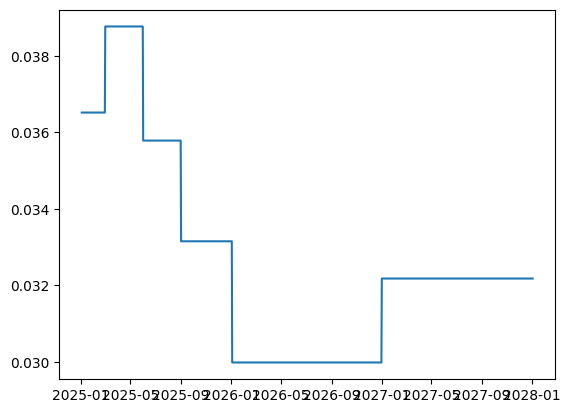

In [58]:
end = '3y'
spx_fwds = eq_curve.curves['SPX'].forwards( end=end, dc=fs.DayCount.Actual360,)
sfr_fwds = eq_curve.curves['SOFR'].forwards( end=end, dc=fs.DayCount.Actual360,)
# (100*(spx_fwds - sfr_fwds)).plot()
spx_fwds.plot()
None

In [59]:
# ! pip install selectolax
# ! pip install h2

import asyncio
import httpx
import pandas as pd
from selectolax.parser import HTMLParser
import nest_asyncio; nest_asyncio.apply()
from typing import Dict, Any, Optional

import asyncio
import httpx
from selectolax.parser import HTMLParser

class CBondsFetcher:
    BASE_URL = "https://cbonds.com/bonds/"

    def __init__(self, bond_id: str, client: httpx.AsyncClient):
        self.bond_id = bond_id
        self.client = client
        self.url = f"{self.BASE_URL}{bond_id}/"
        self._html = None

    async def _get_html(self):
        if self._html:
            return self._html
        resp = await self.client.get(self.url)
        if resp.status_code == 403:
            raise RuntimeError("403 Forbidden — check cf_clearance and cookies")
        resp.raise_for_status()
        self._html = resp.text
        return self._html

    async def fetch_details(self):
        html = await self._get_html()
        tree = HTMLParser(html)
        details = {}
        for tr in tree.css("table tr"):
            tds = tr.css("td")
            if len(tds) == 2:
                k = tds[0].text(strip=True).lower()
                v = tds[1].text(strip=True)
                details[k] = v
        return details


In [60]:
async def main():
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,"
                  "image/webp,image/apng,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
        "Accept-Encoding": "gzip, deflate, br, zstd",
        "Referer": "https://www.google.com/",
        "Sec-CH-UA": '"Brave";v="137", "Chromium";v="137", "Not/A)Brand";v="24"',
        "Sec-CH-UA-Mobile": "?0",
        "Sec-CH-UA-Platform": '"macOS"',
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "cross-site",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
    }

    # Paste from your browser DevTools Application > Cookies
    cookies = {
        "CBONDSSESSID": "is06sre4b2pl89varm493eajr6",
        "cf_clearance": "hQL_eZaudL4LqSLrrbRqcAc4eQZeo.HhZmbf9QEs4C0-1762645747-1.2.1.1-L46PnJK7pU1TY1GzDZ0Xgw_gVzYWoLLn0q4xXxOZDayBXpEmMl8aDcGKODzBmY6L6zbC6SQwnQ6gDxUGf9AsT5BwYOVzDlOLCGUnHr1WLCvt018fCfi1vajERBnvFnVDVBIUwUHN78c.4l6oUDk14rTGiMeFZIxvej70FApdec.NgtniPwbNKXgJm2gxTK.MLTpyDV0BxWvTaGv2L_8rzLrYyc.8IpcEMAvxEs3hV1A",
        "CBONDS_TOKEN1": "907159aa3b50e55cc3bf8b02c0ec121958e3e38ef7d139cad45474afe046044d",
        "CBONDS_TOKEN2": "6d6cea7c320d1f4f62b01483ee8a7088e2fd9efae63a0a5386132d14c37b781bdade76",
        "reg_banner": "true",
    }

    async with httpx.AsyncClient(
        headers=headers,
        cookies=cookies,
        timeout=20.0,
        http2=True,
    ) as client:
        fetcher = CBondsFetcher("746547", client)
        details = await fetcher.fetch_details()
        print(details)


asyncio.run(main())

2025-11-09 13:17:27,929 - DEBUG - httpcore.connection - connect_tcp.started host='cbonds.com' port=443 local_address=None timeout=20.0 socket_options=None
2025-11-09 13:17:27,952 - DEBUG - httpcore.connection - connect_tcp.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7f7c58d68980>
2025-11-09 13:17:27,953 - DEBUG - httpcore.connection - start_tls.started ssl_context=<ssl.SSLContext object at 0x7f7c5609c850> server_hostname='cbonds.com' timeout=20.0
2025-11-09 13:17:27,962 - DEBUG - httpcore.connection - start_tls.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7f7c58d6b8c0>
2025-11-09 13:17:27,963 - DEBUG - httpcore.http2 - send_connection_init.started request=<Request [b'GET']>
2025-11-09 13:17:27,964 - DEBUG - httpcore.http2 - send_connection_init.complete
2025-11-09 13:17:27,966 - DEBUG - httpcore.http2 - send_request_headers.started request=<Request [b'GET']> stream_id=1
2025-11-09 13:17:27,967 - DEBUG - hpack.hpack - Adding (b':met

RuntimeError: 403 Forbidden — check cf_clearance and cookies

In [61]:
import asyncio
import logging
from pathlib import Path
from typing import Optional

import httpx
import pandas as pd

from salt.mkt_data.investingdotcom.bond import InvestingBondFetcher


In [63]:
for x in ('hpack', 'httpcore', 'httpx'):
    logging.getLogger(x).setLevel(logging.INFO)


def main(isin: str, sample_html: Optional[str] = None):
    headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) Chrome/137 Safari/537.36"}
    async def _run():
        async with httpx.AsyncClient(headers=headers, timeout=15.0, http2=True) as client:
            fetcher = InvestingBondFetcher(isin, client)
            if sample_html:
                fetcher._html = Path(sample_html).read_text()
            details = await fetcher.fetch_details()
            quote = await fetcher.fetch_live_quote()
            history = await fetcher.fetch_history()
            bond = await fetcher.build_fs_bond()

            print("DETAILS:", details)
            print("QUOTE:", quote)
            if not history.empty:
                print(history.head())
            else:
                print("No historical data available (offline sample).")
            print("FS BOND:", bond)
            return details, quote, history, bond
    return asyncio.run(_run())


isin = "AT0000A2HLC4"
details, quote, history, bond = main(isin, sample_html="investing_com_html_example.html")


2025-11-09 13:18:04,316 - INFO - httpx - HTTP Request: GET https://www.investing.com/rates-bonds/at0000a2hlc4 "HTTP/2 200 OK"
2025-11-09 13:18:05,597 - INFO - httpx - HTTP Request: GET https://www.investing.com/rates-bonds/at0000a2hlc4-historical-data "HTTP/2 200 OK"


DETAILS: {'name': 'Austria 0,85 GN 2120', 'isin': 'AT0000A2HLC4', 'pair_type': 'Government_traded', 'coupon': 0.85, 'coupon_type': '_bonds_fixed', 'coupon_frequency': '_Annual', 'issue_date': '2020-06-30', 'maturity_date': '2120-06-30 00:00:00', 'next_coupon_date': '2023-11-11', 'duration': '0.00', 'one_year_return_pct': -27.18, 'currency': 'EUR', 'exchange': 'Milan Stock Exchange', 'market': 'Italy'}
QUOTE: {'last': 31.83, 'change': -0.13, 'change_pct': -0.41, 'open': 32.09, 'high': 32.09, 'low': 31.63, 'bid': 31.62, 'ask': 31.9, 'fifty_two_week_high': 48.57, 'fifty_two_week_low': 29.4, 'volume': 4070000, 'currency': 'EUR', 'last_update': '1762533359000', 'price_changes': {'pct_15min': None, 'pct_1d': -0.41, 'pct_1h': None, 'pct_1m': 3.1098, 'pct_1w': -0.5934, 'pct_1y': -27.1791, 'pct_30min': None, 'pct_3m': 2.0519, 'pct_3y': -29.859, 'pct_5y': -75.9955, 'pct_6m': -8.0324, 'pct_all_time': -73.9781, 'pct_ytd': -25.5613, 'updated_at': '2025-11-08T20:59:04.066Z'}}
        date   price   

In [64]:
# 'isin' in page_html
# page_html.split('isin')[-1]
details

{'name': 'Austria 0,85 GN 2120',
 'isin': 'AT0000A2HLC4',
 'pair_type': 'Government_traded',
 'coupon': 0.85,
 'coupon_type': '_bonds_fixed',
 'coupon_frequency': '_Annual',
 'issue_date': '2020-06-30',
 'maturity_date': '2120-06-30 00:00:00',
 'next_coupon_date': '2023-11-11',
 'duration': '0.00',
 'one_year_return_pct': -27.18,
 'currency': 'EUR',
 'exchange': 'Milan Stock Exchange',
 'market': 'Italy'}

In [66]:
quote

{'last': 31.83,
 'change': -0.13,
 'change_pct': -0.41,
 'open': 32.09,
 'high': 32.09,
 'low': 31.63,
 'bid': 31.62,
 'ask': 31.9,
 'fifty_two_week_high': 48.57,
 'fifty_two_week_low': 29.4,
 'volume': 4070000,
 'currency': 'EUR',
 'last_update': '1762533359000',
 'price_changes': {'pct_15min': None,
  'pct_1d': -0.41,
  'pct_1h': None,
  'pct_1m': 3.1098,
  'pct_1w': -0.5934,
  'pct_1y': -27.1791,
  'pct_30min': None,
  'pct_3m': 2.0519,
  'pct_3y': -29.859,
  'pct_5y': -75.9955,
  'pct_6m': -8.0324,
  'pct_all_time': -73.9781,
  'pct_ytd': -25.5613,
  'updated_at': '2025-11-08T20:59:04.066Z'}}

In [67]:
history

,date,price,open,high,low,change_%
0,2025-11-07,31.830,32.090,32.090,31.630,-0.41%
1,2025-11-06,31.960,32.010,32.100,31.860,-0.25%
2,2025-11-05,32.040,32.010,32.090,31.800,+0.28%
3,2025-11-04,31.950,32.010,32.140,31.950,-0.34%
4,2025-11-03,32.060,31.980,32.150,31.910,+0.12%
5,2025-10-31,32.020,31.880,32.180,31.870,-0.25%
6,2025-10-30,32.100,31.740,32.200,31.710,+0.72%
7,2025-10-29,31.870,32.100,32.140,31.820,-0.41%
8,2025-10-28,32.000,32.260,32.260,32.000,-0.09%
9,2025-10-27,32.030,31.800,32.100,31.740,+0.22%


'2 md:text-3xl/8 rtl:ml-1 rtl:soft-ltr">Austria 0,85 GN 2120 (AT0000A2HLC=MI)</h1><span class="relative mr-0 inline-flex pl-2 sm:mx-1.5 sm:pl-0 ltr:order-1 rtl:order-2" style="top:-1px" dir="ltr"><span class="group relative flex items-center justify-evenly gap-0 px-0 py-0 sm:relative sm:items-start sm:gap-2.5 sm:pb-2.5 sm:pt-1 md:pb-3 md:pt-1.5"><div><svg xmlns="http://www.w3.org/2000/svg" width="14" height="14" fill="none" viewBox="0 0 14 14" class="scale-125 sm:scale-100 !scale-100"><g clip-path="url(#info_svg__a)" opacity="0.4"><circle cx="7" cy="7" r="6" stroke="#232526" stroke-linecap="round"></circle><path stroke="#232526" d="M7 6v4.5"></path><path fill="#232526" fill-rule="evenodd" d="M6.2 4a.8.8 0 111.6 0 .8.8 0 01-1.6 0" clip-rule="evenodd"></path></g><defs><clipPath id="info_svg__a"><path fill="#fff" d="M0 0h14v14H0z"></path></clipPath></defs></svg></div><span class="invisible absolute top-5 z-30 group-hover:visible sm:top-0"><span class="-left-2 top-[25px] z-[31] hidden md:a